In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import nolds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm

%matplotlib inline

In [4]:
def freq_feat(data):
    d = abs(data-np.mean(data))
    f = abs(np.fft.fft(d))
    fs = np.fft.fftfreq(len(d),d=1/300)
    cutoff = int(len(d)/10)
    low_cutoff = int(len(d)/600)+1
    
    return [np.mean(f[0:cutoff]), np.std(f[0:cutoff]), stats.skew(f[0:cutoff]), stats.kurtosis(f[0:cutoff]), fs[np.argmax(f[low_cutoff:cutoff])+low_cutoff]]
    

In [5]:
def calc_feat(data):
    feat = []
    feat_nm = ['mean_x', 'mean_y', 'mean_z', 'mean_mag', 'std_x', 'std_y', 'std_z', 'std_mag',
               'skew_x', 'skew_y', 'skew_z', 'skew_mag', 'kurt_x', 'kurt_y', 'kurt_z', 'kurt_mag',
               'sen_x', 'sen_y', 'sen_z', 'sen_mag', 'fmean', 'fstd', 'fskew', 'fkurt', 'ffreq',
               'mean_gx', 'mean_gy', 'mean_gz', 'mean_gmag', 'std_gx', 'std_gy', 'std_gz', 'std_gmag',
               'skew_gx', 'skew_gy', 'skew_gz', 'skew_gmag', 'kurt_gx', 'kurt_gy', 'kurt_gz', 'kurt_gmag',
               'sen_gx', 'sen_gy', 'sen_gz', 'sen_gmag', 'fmean_g', 'fstd_g', 'fskew_g', 'fkurt_g', 'ffreq_g']
    
    ts = data['time(s)']
    x = data['x(g)']
    y = data['y(g)']
    z = data['z(g)']
    mag = (x**2+y**2+z**2)**.5
    
    gx = data['gx']
    gy = data['gy']
    gz = data['gz']
    gmag = (gx**2+gy**2+gz**2)**.5
    
    feat.append(np.mean(x)), feat.append(np.mean(y)), feat.append(np.mean(z)), feat.append(np.mean(mag))
    feat.append(np.std(x)), feat.append(np.std(y)), feat.append(np.std(z)), feat.append(np.std(mag))
    feat.append(stats.skew(x)), feat.append(stats.skew(y)), feat.append(stats.skew(z)), feat.append(stats.skew(mag))
    feat.append(stats.kurtosis(x)), feat.append(stats.kurtosis(y)), feat.append(stats.kurtosis(z)), feat.append(stats.kurtosis(mag))
    
    feat.append(nolds.sampen(x[::5])), feat.append(nolds.sampen(y[::5])), feat.append(nolds.sampen(z[::5])), feat.append(nolds.sampen(mag[::5]))

    for val in freq_feat(mag.values):
        feat.append(val)
    
    feat.append(np.mean(gx)), feat.append(np.mean(gy)), feat.append(np.mean(gz)), feat.append(np.mean(gmag))
    feat.append(np.std(gx)), feat.append(np.std(gy)), feat.append(np.std(gz)), feat.append(np.std(gmag))
    feat.append(stats.skew(gx)), feat.append(stats.skew(gy)), feat.append(stats.skew(gz)), feat.append(stats.skew(gmag))
    feat.append(stats.kurtosis(gx)), feat.append(stats.kurtosis(gy)), feat.append(stats.kurtosis(gz)), feat.append(stats.kurtosis(gmag))
    
    feat.append(nolds.sampen(gx[::5])), feat.append(nolds.sampen(gy[::5])), feat.append(nolds.sampen(gz[::5])), feat.append(nolds.sampen(gmag[::5]))
    
    for val in freq_feat(gmag.values):
        feat.append(val)
    
    return pd.Series(data = feat, index = feat_nm)

In [6]:
def gen_clips(data, clipsize=60, overlap = .5):
    Features = pd.DataFrame(columns = ['mean_x', 'mean_y', 'mean_z', 'mean_mag', 'std_x', 'std_y', 'std_z', 'std_mag',
               'skew_x', 'skew_y', 'skew_z', 'skew_mag', 'kurt_x', 'kurt_y', 'kurt_z', 'kurt_mag',
               'sen_x', 'sen_y', 'sen_z', 'sen_mag', 'fmean', 'fstd', 'fskew', 'fkurt', 'ffreq',
               'mean_gx', 'mean_gy', 'mean_gz', 'mean_gmag', 'std_gx', 'std_gy', 'std_gz', 'std_gmag',
               'skew_gx', 'skew_gy', 'skew_gz', 'skew_gmag', 'kurt_gx', 'kurt_gy', 'kurt_gz', 'kurt_gmag',
               'sen_gx', 'sen_gy', 'sen_gz', 'sen_gmag', 'fmean_g', 'fstd_g', 'fskew_g', 'fkurt_g', 'ffreq_g'])
    ts = data['time(s)']
    tslen = max(ts)-min(ts)
    for ind in range(int((tslen-clipsize)/(clipsize*(1-overlap)))+1):
        start_ts = min(ts)+ind*(clipsize*(1-overlap))
        clipInds = (ts>=start_ts) & (ts<(start_ts+clipsize))
        Features.loc[start_ts,:] = calc_feat(data[clipInds])
        
    return Features
        
    

In [7]:
CPFeat = pd.DataFrame(columns=['mean_x', 'mean_y', 'mean_z', 'mean_mag', 'std_x', 'std_y', 'std_z', 'std_mag',
               'skew_x', 'skew_y', 'skew_z', 'skew_mag', 'kurt_x', 'kurt_y', 'kurt_z', 'kurt_mag',
               'sen_x', 'sen_y', 'sen_z', 'sen_mag', 'fmean', 'fstd', 'fskew', 'fkurt', 'ffreq',
               'mean_gx', 'mean_gy', 'mean_gz', 'mean_gmag', 'std_gx', 'std_gy', 'std_gz', 'std_gmag',
               'skew_gx', 'skew_gy', 'skew_gz', 'skew_gmag', 'kurt_gx', 'kurt_gy', 'kurt_gz', 'kurt_gmag',
               'sen_gx', 'sen_gy', 'sen_gz', 'sen_gmag', 'fmean_g', 'fstd_g', 'fskew_g', 'fkurt_g', 'ffreq_g'])
NormFeat = pd.DataFrame(columns=['mean_x', 'mean_y', 'mean_z', 'mean_mag', 'std_x', 'std_y', 'std_z', 'std_mag',
               'skew_x', 'skew_y', 'skew_z', 'skew_mag', 'kurt_x', 'kurt_y', 'kurt_z', 'kurt_mag',
               'sen_x', 'sen_y', 'sen_z', 'sen_mag', 'fmean', 'fstd', 'fskew', 'fkurt', 'ffreq',
               'mean_gx', 'mean_gy', 'mean_gz', 'mean_gmag', 'std_gx', 'std_gy', 'std_gz', 'std_gmag',
               'skew_gx', 'skew_gy', 'skew_gz', 'skew_gmag', 'kurt_gx', 'kurt_gy', 'kurt_gz', 'kurt_gmag',
               'sen_gx', 'sen_gy', 'sen_gz', 'sen_gmag', 'fmean_g', 'fstd_g', 'fskew_g', 'fkurt_g', 'ffreq_g'])

In [8]:
for ind in ['1', '2', '3', '4']:
    CP = pd.read_csv('CP/CP/dev' + ind + '.txt',sep='\t')
    Normal = pd.read_csv('CP/Normal/dev' + ind + '.txt',sep='\t')
    
    CP = gen_clips(CP,overlap=.75)
    Normal = gen_clips(Normal,overlap=.75)
    
    CPFeat = pd.concat((CPFeat,CP),axis=0)
    NormFeat = pd.concat((NormFeat,Normal),axis=0)

In [9]:
pca = PCA()
scaler = StandardScaler()

In [10]:
featList = ['mean_mag', 'std_mag', 'skew_mag', 'kurt_mag','sen_mag', 'fmean', 'fstd', 'fskew', 'fkurt', 'ffreq',
            'mean_gmag', 'std_gmag', 'skew_gmag', 'kurt_gmag','sen_gmag','fmean_g', 'fstd_g', 'fskew_g', 'fkurt_g', 'ffreq_g']

In [11]:
Feat = pd.concat((NormFeat.loc[:,featList],CPFeat.loc[:,featList]))

In [12]:
Feat.loc[:,:] = scaler.fit_transform(Feat)

In [13]:
P = pca.fit_transform(Feat)

In [14]:
c = ['b', 'r']
col = c[1]*len(NormFeat)+c[0]*len(CPFeat)

In [15]:
Feat.iloc[len(NormFeat):,:].mean()

mean_mag    -0.492770
std_mag     -0.724299
skew_mag    -0.058611
kurt_mag     0.111794
sen_mag      0.007301
fmean       -0.736964
fstd        -0.702681
fskew       -0.197941
fkurt       -0.234574
ffreq       -0.058797
mean_gmag   -0.489640
std_gmag    -0.604913
skew_gmag   -0.000003
kurt_gmag   -0.115017
sen_gmag    -0.457413
fmean_g     -0.653949
fstd_g      -0.631203
fskew_g     -0.448103
fkurt_g     -0.406261
ffreq_g     -0.375258
dtype: float64

In [16]:
Feat.iloc[0:len(NormFeat),:].mean()

mean_mag     0.533834
std_mag      0.784658
skew_mag     0.063495
kurt_mag    -0.121110
sen_mag     -0.007910
fmean        0.798378
fstd         0.761238
fskew        0.214437
fkurt        0.254121
ffreq        0.063696
mean_gmag    0.530444
std_gmag     0.655323
skew_gmag    0.000004
kurt_gmag    0.124601
sen_gmag     0.495530
fmean_g      0.708445
fstd_g       0.683803
fskew_g      0.485445
fkurt_g      0.440116
ffreq_g      0.406530
dtype: float64

In [17]:
Feat

,mean_mag,std_mag,skew_mag,kurt_mag,sen_mag,fmean,fstd,fskew,fkurt,ffreq,mean_gmag,std_gmag,skew_gmag,kurt_gmag,sen_gmag,fmean_g,fstd_g,fskew_g,fkurt_g,ffreq_g
0.00,0.558687,0.779363,0.034745,-0.328557,-0.313558,1.960338,1.829824,1.408978,1.870572,1.422403,0.422274,0.451034,-0.540015,-0.449092,-0.035328,1.217375,1.666623,3.000525,3.698682,-0.643196
15.00,0.728120,0.918215,-0.053883,-0.365806,-0.244706,2.187521,2.072686,1.772778,2.352004,-0.529428,0.561350,0.517096,-0.585119,-0.487617,0.269113,1.316887,1.766019,2.842778,3.514532,-0.588074
30.00,0.834311,0.999813,-0.154112,-0.393461,0.326461,2.311035,2.260749,2.282489,3.057715,0.384435,0.772775,0.466124,-0.587677,-0.475436,1.072058,1.291676,1.662671,2.911010,3.595809,-0.661570
45.00,1.176314,1.264228,-0.248321,-0.432648,0.252909,2.668034,2.738819,2.700875,3.591712,-0.642251,0.836881,0.492202,-0.661274,-0.514691,1.154423,1.401465,1.690613,3.075930,3.780180,-0.661570
60.00,0.815738,0.836044,-0.244903,-0.414597,0.400570,2.060575,2.051289,2.908385,3.896600,-0.642251,0.604378,0.115289,-0.881753,-0.606001,1.601756,0.745007,1.079464,3.336559,4.082794,1.139085
75.00,0.728406,0.782793,-0.231743,-0.406359,0.306666,1.981154,1.944200,2.823550,3.777317,0.813161,0.535577,0.100195,-0.810320,-0.489347,1.427687,0.786928,1.044349,3.634304,4.458503,-0.441082
90.00,0.712973,0.765451,-0.201568,-0.397889,0.281809,1.934284,1.923661,2.777085,3.722290,-0.134549,0.506118,0.113810,-0.731567,-0.477221,1.384448,0.829970,1.039567,3.354367,4.115507,0.036643
105.00,0.410917,0.497257,-0.042058,-0.297706,0.346169,1.619875,1.404992,2.391648,3.244674,-0.529428,0.416853,0.206298,0.289804,0.383109,1.084035,0.949521,1.097445,2.094951,2.599971,0.440872
120.00,0.402243,0.449429,-0.039181,-0.293675,0.319120,1.616908,1.275618,2.193468,3.009842,-0.529428,0.444292,0.296990,0.083764,0.135509,1.025957,1.064297,1.263206,2.084173,2.613752,-0.716692
135.00,0.411853,0.397049,-0.042963,-0.272744,0.593688,1.536399,1.233247,2.624998,3.579505,-0.597122,0.436234,0.213006,0.070516,0.214560,1.336604,0.893015,1.150433,2.214259,2.769433,-0.753440


In [18]:
P.shape

(175, 20)

In [19]:
pca.components_

array([[ 1.94774797e-01,  3.07455580e-01, -1.00092897e-01,
        -1.51764589e-01, -3.40773349e-03,  3.19960453e-01,
         3.31313329e-01,  1.96809035e-01,  2.01211772e-01,
         1.60080685e-02,  2.80509725e-01,  2.82060444e-01,
        -1.33911427e-01, -1.02196629e-01,  1.76498401e-01,
         2.99300332e-01,  3.14871461e-01,  2.55740908e-01,
         2.39262450e-01,  1.17068971e-01],
       [-4.76906693e-02, -2.05859489e-01, -3.34389471e-01,
        -2.46806339e-01,  3.09851444e-01, -1.41515648e-01,
        -1.14986576e-01,  3.45603705e-01,  3.12638967e-01,
         3.42783126e-02, -1.40530537e-01, -2.38750987e-01,
        -3.02234823e-01, -2.92384843e-01,  1.65196756e-01,
        -2.11679523e-01, -1.70717043e-01,  1.82975489e-01,
         1.87260000e-01, -1.07827379e-01],
       [-1.00349206e-02, -7.38907058e-02,  3.38593026e-01,
         3.64801309e-01,  2.95712091e-01,  3.95175750e-02,
         1.18074150e-02,  2.27692956e-01,  2.93597456e-01,
         3.76692657e-02, -5.8

In [20]:
len(col)

175

In [34]:
np.array(range(0,20))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

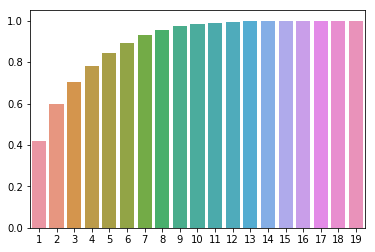

In [39]:
sns.barplot(x = np.array(range(1,20)),y= [sum(pca.explained_variance_ratio_[0:k]) for k in range(1,20)])

In [40]:
[sum(pca.explained_variance_ratio_[0:k]) for k in range(1,20)]

[0.4186634860793146,
 0.5986544982501287,
 0.703201253180845,
 0.7819080561859466,
 0.8439759297944373,
 0.8902748975017658,
 0.9307773934454538,
 0.9564113904087852,
 0.976085155247736,
 0.9841078139100464,
 0.9896230139551985,
 0.9937492079630613,
 0.9967045992865876,
 0.9985893533313445,
 0.999236603969359,
 0.9995979400041725,
 0.9997806807943742,
 0.9999206437423424,
 0.9999864856749624]

In [22]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [23]:
abr_featList = ['mean_acc','std_acc','skew_acc','kurt_acc','sen_acc','fmean_acc','fstd_acc','fskew_acc','fkurt_acc','freq_acc',
                'mean_gyr','std_gyr','skew_gyr','kurt_gyr','sen_gyr','fmean_gyr','fstd_gyr','fskew_gyr','fkurt_gyr','freq_gyr']

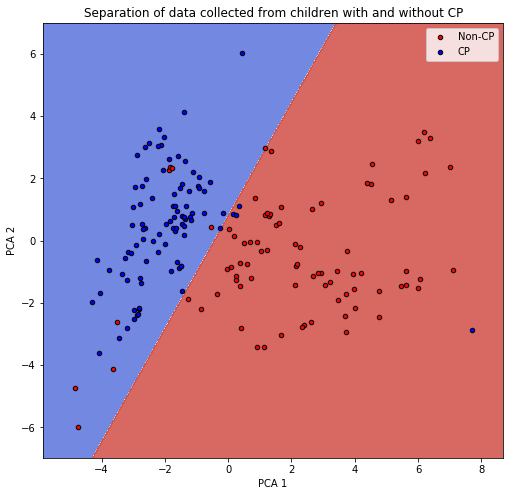

In [27]:
cf = svm.SVC(kernel='linear')
y = list([1]*len(NormFeat)+[0]*len(CPFeat))
cf.fit(P[:,0:2],y)

plt.figure(figsize=(8.25,8))
ax = plt.axes()
xx, yy = make_meshgrid(P[:,0], P[:,1])
# plot_contours(ax, cf, xx, yy,
#               cmap=plt.cm.coolwarm, alpha=0.8)

Z = cf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

ax.scatter(P[0:len(NormFeat),0], P[0:len(NormFeat),1], c='r', s=20, edgecolors='k',label='Non-CP')
ax.scatter(P[len(NormFeat):,0], P[len(NormFeat):,1], c='b', s=20, edgecolors='k',label='CP')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Separation of data collected from children with and without CP')
ax.legend()

plt.savefig('Scatter.png')

In [52]:
cf = svm.SVC(kernel='linear')
y = list([1]*len(NormFeat)+[0]*len(CPFeat))
cf.fit(P[:,0:3],y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
cf.predict(P[:,0:3])-y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [237]:
(len(NormFeat)-10)/len(NormFeat)

0.8809523809523809

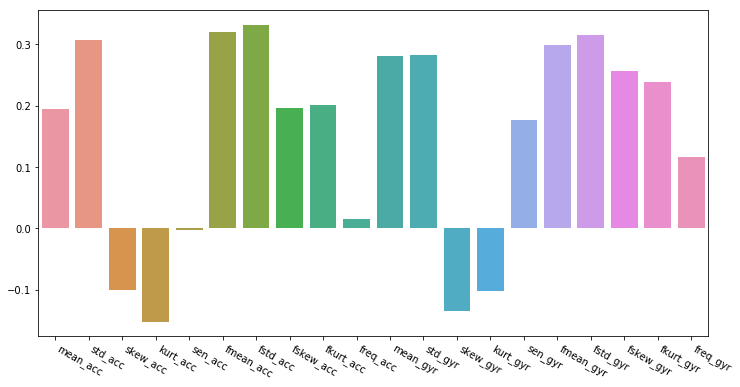

In [223]:
plt.figure(figsize=(12,6))
ax = sns.barplot(y = pca.components_[0,:],x=abr_featList)
temp = ax.set_xticklabels(labels=abr_featList,rotation=-30,ha='left')
plt.savefig('Comp1.png')

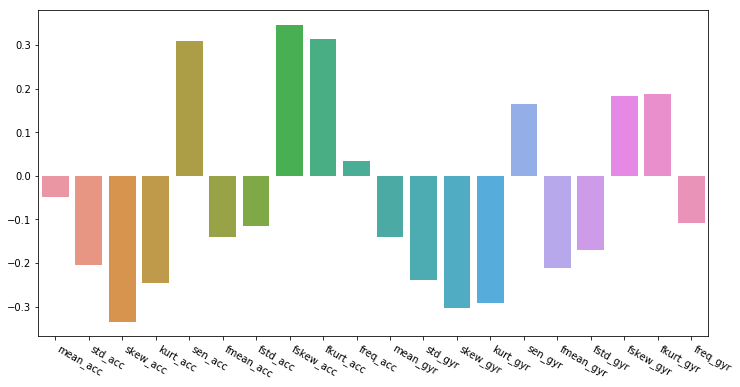

In [224]:
plt.figure(figsize=(12,6))
f = sns.barplot(y = pca.components_[1,:],x=abr_featList)
temp = f.set_xticklabels(labels=abr_featList,rotation=-30,ha='left')
plt.savefig('Comp2.png')

In [239]:
for feat, ab_feat in zip(featList, abr_featList):
    print(feat, stats.ttest_ind(Feat.iloc[0:len(NormFeat),:][feat], Feat.iloc[len(NormFeat):,:][feat]))

mean_mag Ttest_indResult(statistic=7.858353239465859, pvalue=3.968039757026082e-13)
std_mag Ttest_indResult(statistic=15.0919246132987, pvalue=2.208183346873806e-33)
skew_mag Ttest_indResult(statistic=0.803878245868768, pvalue=0.4225704981134101)
kurt_mag Ttest_indResult(statistic=-1.5409297565454845, pvalue=0.12516101618171294)
sen_mag Ttest_indResult(statistic=-0.09995886112051475, pvalue=0.9204927263157257)
fmean Ttest_indResult(statistic=15.725346581114177, pvalue=3.548523191117132e-35)
fstd Ttest_indResult(statistic=14.105642991180892, pvalue=1.4393146975157293e-30)
fskew Ttest_indResult(statistic=2.7692305152952694, pvalue=0.006232029705964907)
fkurt Ttest_indResult(statistic=3.311535500959808, pvalue=0.0011295361873676075)
ffreq Ttest_indResult(statistic=0.8064394518460419, pvalue=0.4210967085912922)
mean_gmag Ttest_indResult(statistic=7.790858448183361, pvalue=5.89707948381817e-13)
std_gmag Ttest_indResult(statistic=10.65926340499245, pvalue=1.0315839658250422e-20)
skew_gmag Tt

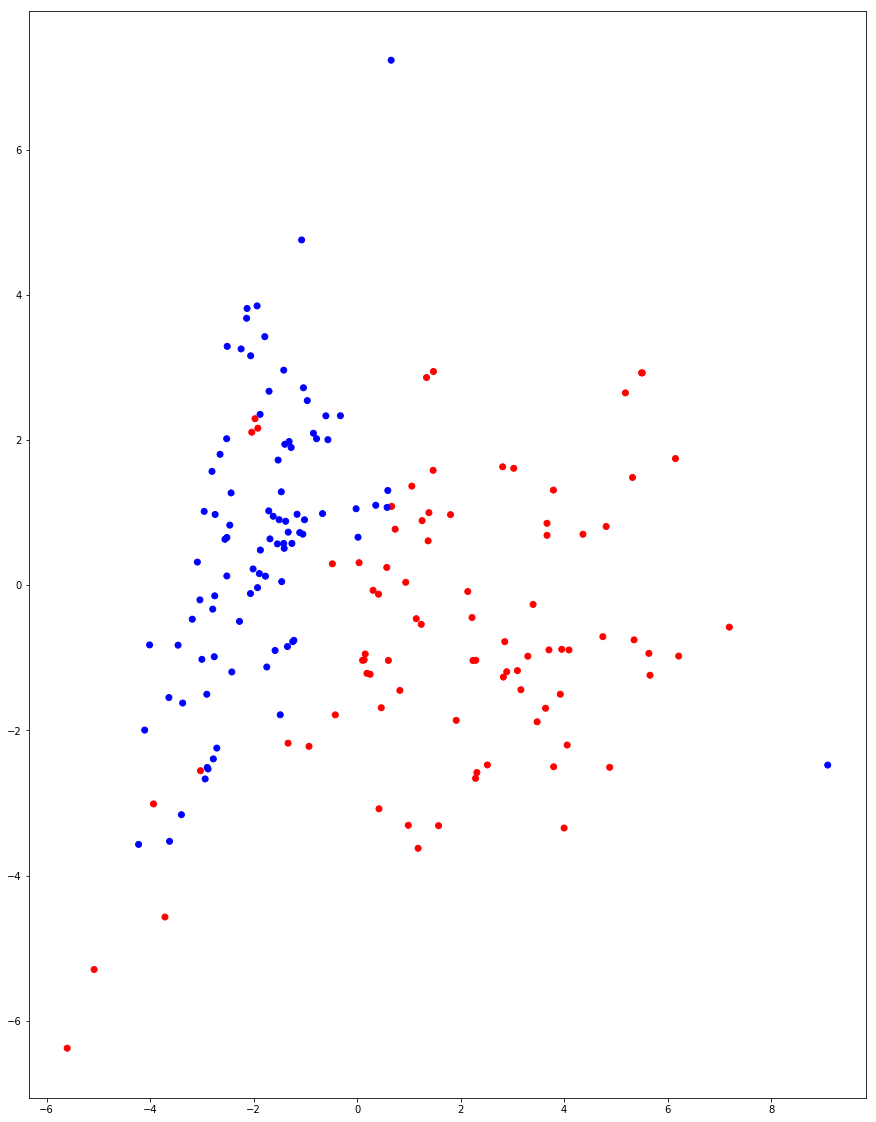

In [32]:
# Overlap = .75, all
plt.figure(figsize=(15,20))
plt.scatter(P[:,0],P[:,1],c = col)

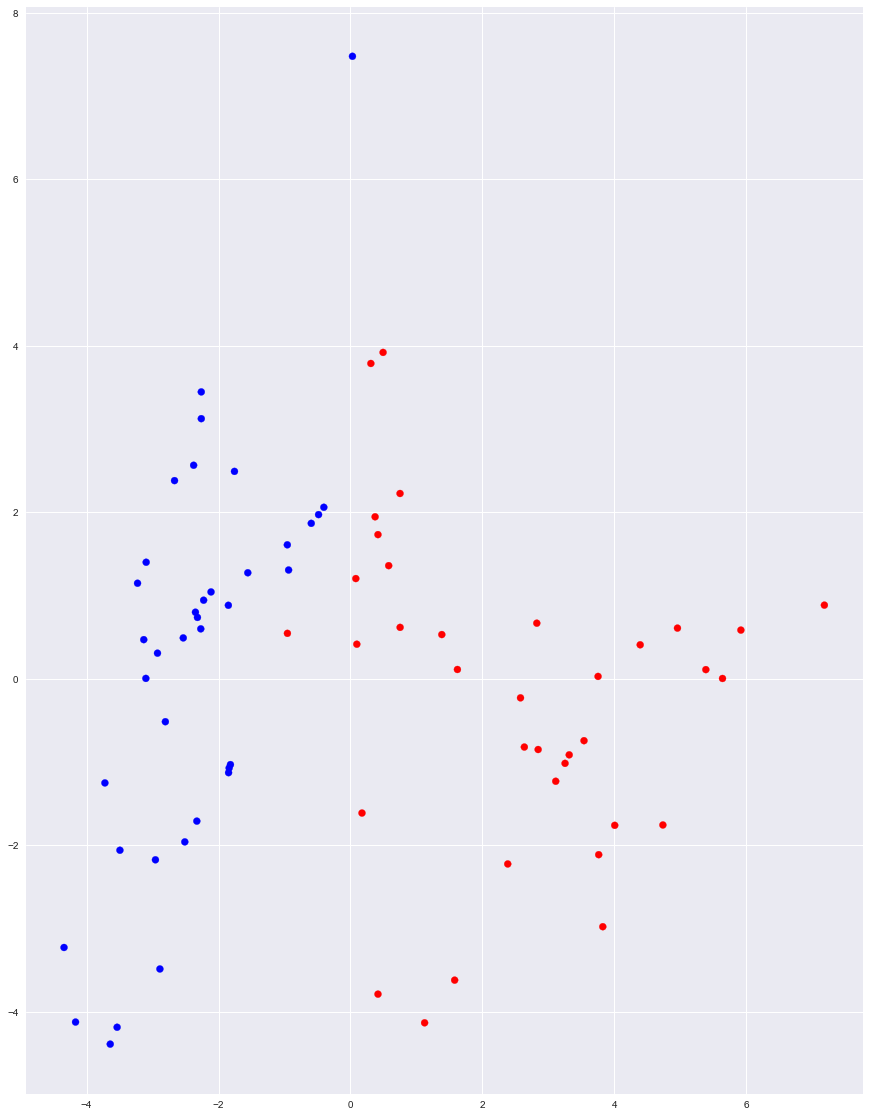

In [88]:
# Overlap = .75, dev4
plt.figure(figsize=(15,20))
plt.scatter(P[:,0],P[:,1],c = col)

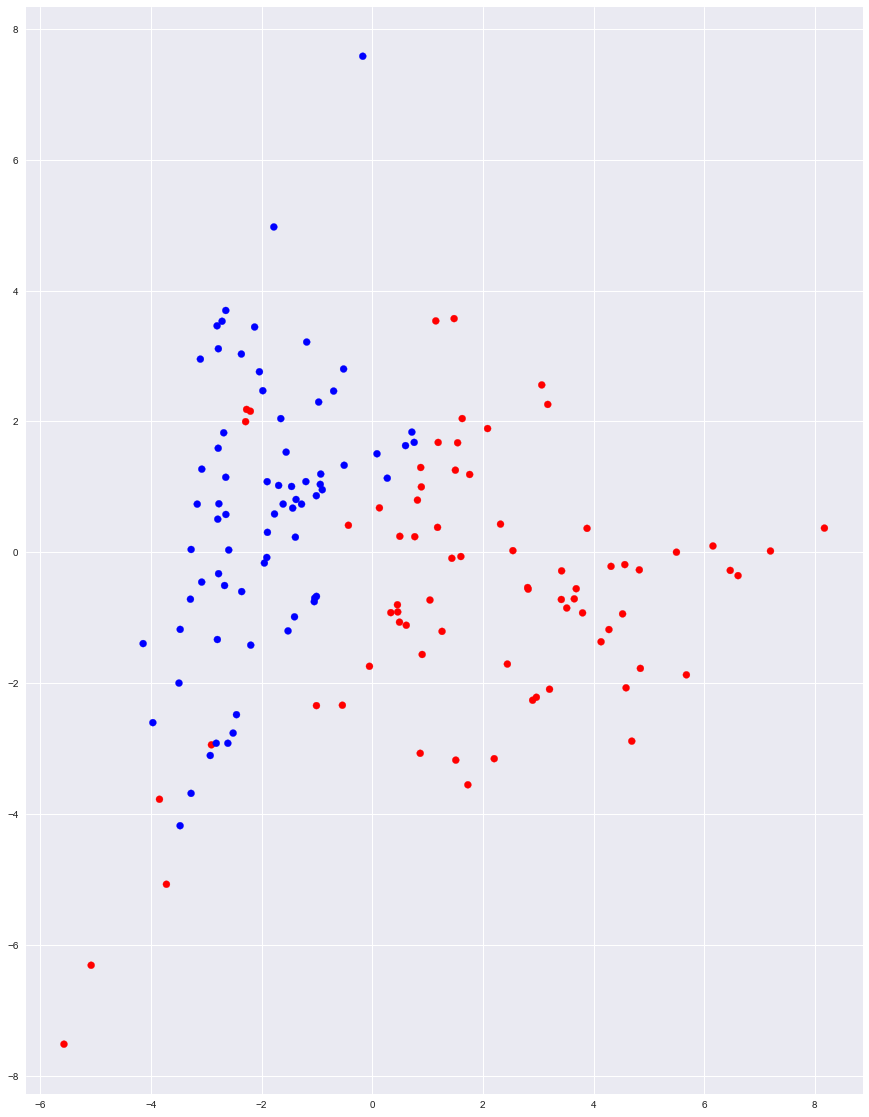

In [97]:
# Overlap = .75, dev3
plt.figure(figsize=(15,20))
plt.scatter(P[:,0],P[:,1],c = col)

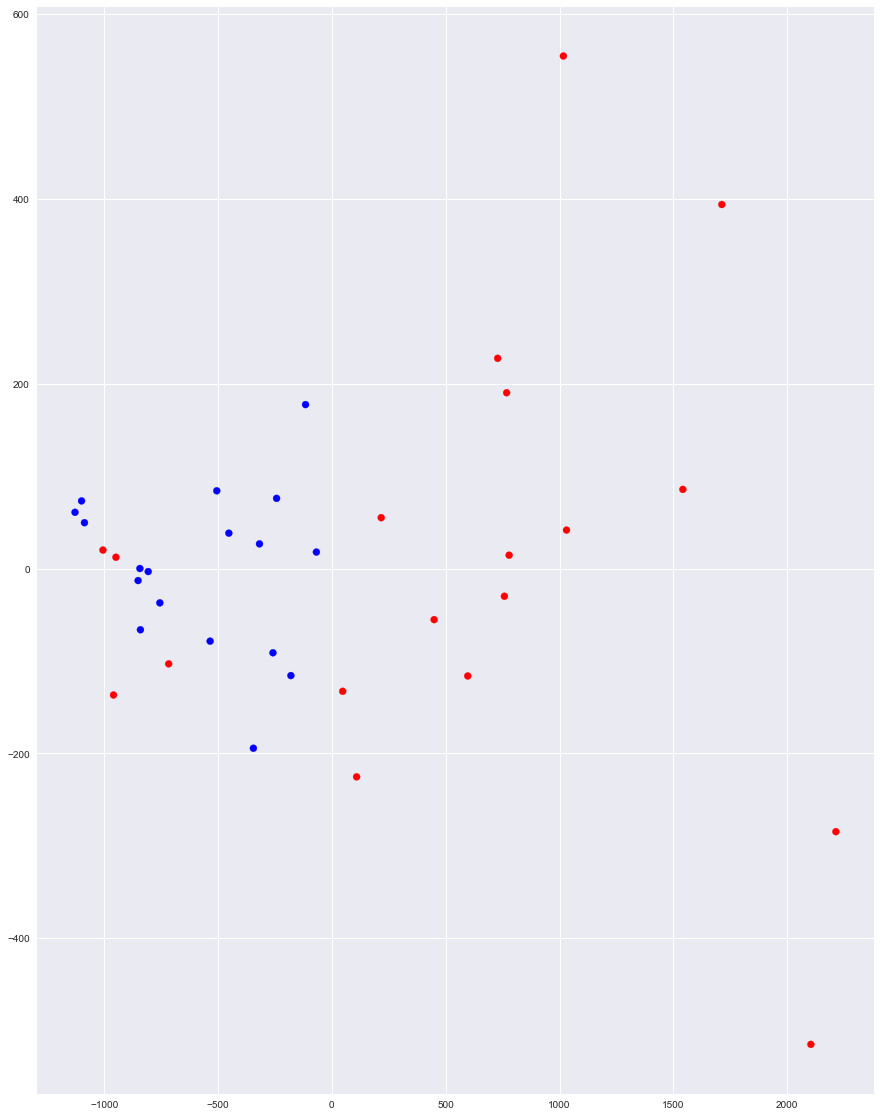

In [45]:

# Overlap = .5
plt.figure(figsize=(15,20))
plt.scatter(P[:,0],P[:,1],c = col)

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


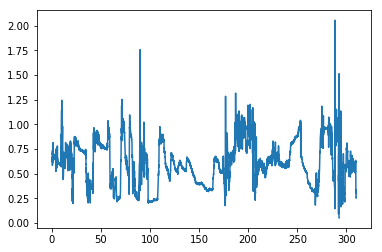

In [26]:
plt.plot(D['time(s)'],D.apply(lambda x: (x['x(g)']**2 + x['y(g)']**2 + x['z(g)'])**.5,axis=1)*0.0312)

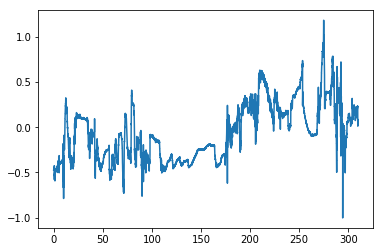

In [27]:
plt.plot(D['time(s)'],D['x(g)']*0.0312)

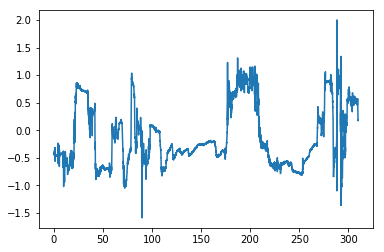

In [28]:
plt.plot(D['time(s)'],D['y(g)']*0.0312)

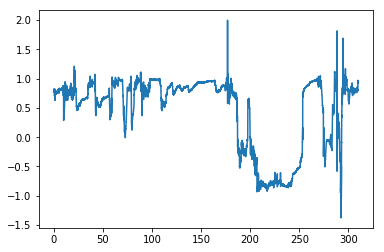

In [29]:
plt.plot(D['time(s)'],D['z(g)']*0.0312)